In [1]:
import os
import h5py
import numpy as np
import sys

from unwrap import unwrap

sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import cptools as cp
from library import dspec

from ipywidgets import interact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# configure matplotlib
mpl.style.use("classic")

## Load Data

In [2]:
# data path
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2_AVG.h5"
modelpath = "/lustre/aoc/projects/hera/pkeller/data/model/model_EQ14_FC_B2.h5"

# load data
with h5py.File(path, "r") as f:
    frq = f["FRQ"][()]
    lst = f["LST"][()]
    eicp1_xx = f["eicp XX 1"][()]
    eicp2_xx = f["eicp XX 2"][()]
    eicp1_yy = f["eicp YY 1"][()]
    eicp2_yy = f["eicp YY 2"][()]

## Apply Scaling

In [3]:
# load scaling coefficients
with h5py.File(modelpath, "r") as f:
    A = f["Data/Scaling"][()]

# apply scaling coefficients
for i in range(len(lst)):
    eicp1_xx[:, :, i] = np.sqrt(A[i]) * eicp1_xx[:, :, i]
    eicp1_yy[:, :, i] = np.sqrt(A[i]) * eicp1_yy[:, :, i]
    eicp2_xx[:, :, i] = np.sqrt(A[i]) * eicp2_xx[:, :, i]
    eicp2_yy[:, :, i] = np.sqrt(A[i]) * eicp2_yy[:, :, i]

## Weighted Average over Triads

In [8]:
# compute inverse variance weights
var_xx = np.var(eicp1_xx[1] - eicp1_xx[0], axis=-1) / np.sqrt(2)
var_yy = np.var(eicp1_yy[1] - eicp1_yy[0], axis=-1) / np.sqrt(2)
w_xx = 1 / np.moveaxis([np.outer(var_xx[:, i], var_xx[:, i]) for i in range(var_xx.shape[1])], 0, -1)
w_yy = 1 / np.moveaxis([np.outer(var_yy[:, i], var_yy[:, i]) for i in range(var_yy.shape[1])], 0, -1)

# average over triads
cp1_xx = np.angle((np.moveaxis(eicp1_xx, -1, 0) / var_xx).sum(axis=2) / np.sum(1 / var_xx, axis=0))
cp2_xx = np.angle((np.moveaxis(eicp2_xx, -1, 0) / var_xx).sum(axis=2) / np.sum(1 / var_xx, axis=0))
cp1_yy = np.angle((np.moveaxis(eicp1_yy, -1, 0) / var_yy).sum(axis=2) / np.sum(1 / var_yy, axis=0))
cp2_yy = np.angle((np.moveaxis(eicp2_yy, -1, 0) / var_yy).sum(axis=2) / np.sum(1 / var_yy, axis=0))

print(cp1_xx.shape, cp2_xx.shape, cp1_yy.shape, cp2_yy.shape)

(161, 2, 47) (161, 4, 47) (161, 2, 47) (161, 4, 47)


## Unwrap Phase

In [9]:
# unwrap phase
cp1_xx = np.unwrap(cp1_xx, axis=0)
cp2_xx = np.unwrap(cp2_xx, axis=0)
cp1_yy = np.unwrap(cp1_yy, axis=0)
cp2_yy = np.unwrap(cp2_yy, axis=0)

# adjust mean of unwraped closure phase
cp1_xx = np.moveaxis(cp1_xx - np.mean(cp1_xx, axis=0) + A, 0, -1)
cp2_xx = np.moveaxis(cp2_xx - np.mean(cp2_xx, axis=0) + A, 0, -1)
cp1_yy = np.moveaxis(cp1_yy - np.mean(cp1_yy, axis=0) + A, 0, -1)
cp2_yy = np.moveaxis(cp2_yy - np.mean(cp2_yy, axis=0) + A, 0, -1)

## Compute Cross-Power Spectrum

In [14]:
# cross-power spectra of unwraped closure phase
xps_xx = dspec.welch(cp1_xx[0], cp1_xx[1], fs=10.24*1e-6, shift=True)
xps_yy = dspec.welch(cp1_yy[0], cp1_yy[1], fs=10.24*1e-6, shift=True)

# compute cross-power errors of unwraped closure phase
dcp_xx = (cp2_xx[np.newaxis, :] - cp2_xx[:, np.newaxis]) / 2
dcp_yy = (cp2_yy[np.newaxis, :] - cp2_yy[:, np.newaxis]) / 2
indices = [[0, 1, 2, 3], [0, 2, 1, 3], [0, 3, 1, 2]]
dcp_xx = np.array([[dcp_xx[i, j], dcp_xx[k, l]] for [i, j, k, l] in indices])
dcp_yy = np.array([[dcp_yy[i, j], dcp_yy[k, l]] for [i, j, k, l] in indices])
err_xx = np.array([dspec.welch(dcp_xx[i, 0], dcp_xx[i, 1], 10.24*1e-6) for i in range(3)])
err_yy = np.array([dspec.welch(dcp_yy[i, 0], dcp_yy[i, 1], 10.24*1e-6) for i in range(3)])

print(xps_xx.shape, xps_yy.shape, err_xx.shape, err_yy.shape)

(47, 161) (47, 161) (3, 47, 161) (3, 47, 161)


## Average in LST

In [22]:
idx = np.where((lst > 4.75) & (lst < 5.25))
lst_weights_xx = np.median(np.abs(err_xx)**2, axis=(0, -1))
lst_weights_yy = np.median(np.abs(err_yy)**2, axis=(0, -1))
lst_weights_xx[idx] = 0
lst_weights_yy[idx] = 0

xps_xx_avg = (xps_xx.swapaxes(-1, -2) * lst_weights_xx).sum(axis=-1) / lst_weights_xx.sum()
xps_yy_avg = (xps_xx.swapaxes(-1, -2) * lst_weights_yy).sum(axis=-1) / lst_weights_yy.sum()
err_xx_avg = (err_xx.swapaxes(-1, -2) * lst_weights_xx).sum(axis=-1) / lst_weights_xx.sum()
err_yy_avg = (err_xx.swapaxes(-1, -2) * lst_weights_yy).sum(axis=-1) / lst_weights_yy.sum()

print(xps_xx_avg.shape)

(161,)


## Plot

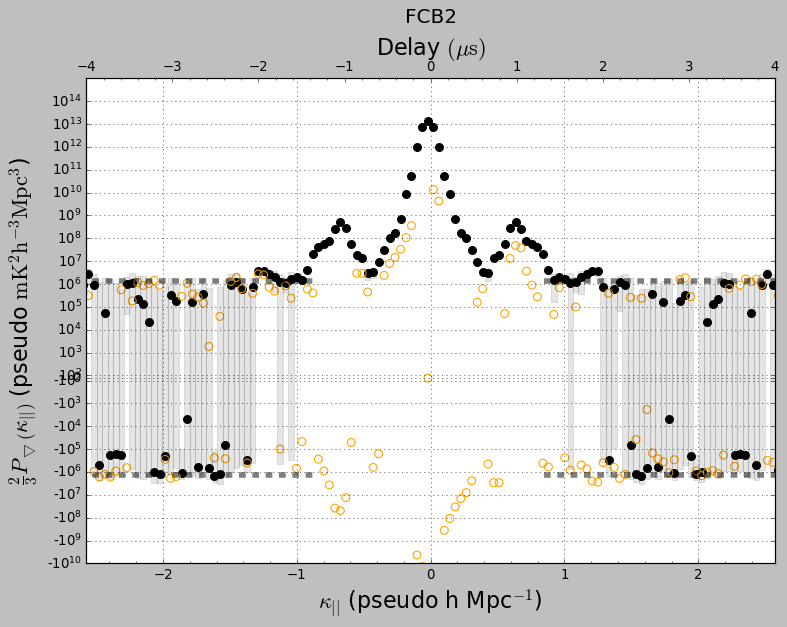

In [25]:
delay=dspec.delay(n=xps_xx_avg.shape[-1])
dspec.power_plot(
    delay,
    xps_yy_avg, 
    np.mean(np.abs(err_yy_avg), axis=0),
    linthresh=1e3,
    legend=False,
    onesided=False,
    title="FCB2",
)

In [15]:
phase = np.zeros_like(bispec).astype(float)

for i in range(phase.shape[0]):
    for j in range(phase.shape[1]):
        phase[i, j] = unwrap(np.angle(bispec[i, j]))
print(phase.shape)

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


(2, 77, 47, 161)


In [37]:
mbispec = np.mean(bispec, axis=1)
mphase = np.moveaxis(np.unwrap(np.angle(mbispec), axis=-1), -1, 0)
mphase = np.moveaxis(mphase - np.mean(mphase, axis=0), 0, -1)


In [29]:
def plot(j, tr):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    im1 = ax.imshow(
        np.flip(cp2_xx[j], axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.plasma,
        interpolation="None",
        aspect="auto")


    ax.set_title(f"JD Bin {j}, Bispectrum Phase")
    plt.setp(ax, xlabel="Feequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot,j=(0, 3, 1), tr=(0, cp1_xx.shape[1]-1))

interactive(children=(IntSlider(value=1, description='j', max=3), IntSlider(value=23, description='tr', max=46…

<function __main__.plot(j, tr)>

In [56]:
xps = dspec.welch(mphase[0], mphase[1], fs=10.24*1e-6, shift=True)
delay = dspec.delay(n=xps.shape[-1])

In [54]:
print(delay.shape, xps.shape)

(161,) (47, 161)


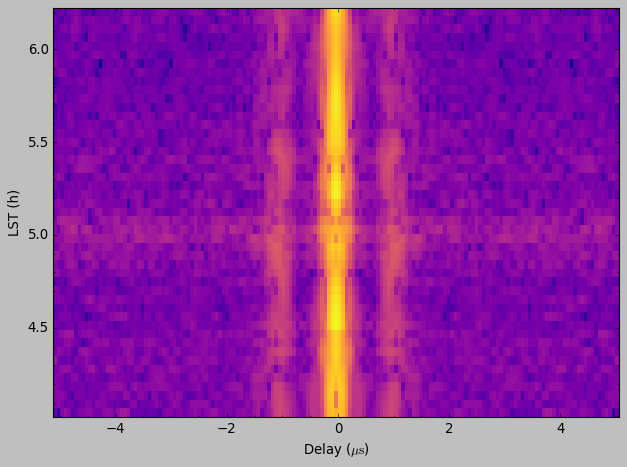

In [31]:
im = plt.imshow(
    np.flip(np.abs(xps_yy), axis=0),
    extent=(np.amin(delay), np.amax(delay), np.amin(lst), np.amax(lst)),
    cmap=cm.plasma,
    interpolation="None",
    aspect="auto",    
    norm=mpl.colors.LogNorm()
)
    
plt.xlabel(r"Delay ($\mu\mathrm{s}$)")
plt.ylabel("LST (h)")
plt.ylim([min(lst), max(lst)])
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [20]:
def plot(pol, j, tr):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    im1 = ax.imshow(
        np.angle(bispec[pol, j, tr]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto")


    ax.set_title(f"JD {jd[j]}, Bispectrum Phase")
    plt.setp(ax, xlabel="Fe5quency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot, pol=(0, 1), j=(0, len(jd)-1, 1), tr=(0, phase.shape[2]))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=40, description='j', max=8…

<function __main__.plot(pol, j, tr)>

In [37]:
print(mbispec.shape)

(82, 752, 161)


In [38]:
def plot(pol, tr, t):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.plot(frq, np.swapaxes(np.angle(mbispec[:, t]), 0, 1), linewidth=0, marker="o", markersize=2, markeredgewidth=0)
    
    plt.tight_layout()
    plt.show()

interact(plot, pol=(0, 1), tr=(0, mbispec.shape[-3]), t=(0, mbispec.shape[-2]-1))

interactive(children=(IntSlider(value=0, description='pol', max=1), IntSlider(value=41, description='tr', max=…

<function __main__.plot(pol, tr, t)>